In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
from scipy.optimize import root

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)
#notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

# data set when at office 
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
# data set when at home

In [382]:
cap = 0.211

Ms = 32
F = 9.649e4

R = 8.3145
T = 298
ar = 0.960
I = cap*0.2#1.7
nu = 0.0114

#f_l = np.sqrt(nu*Ms/2)# (Ms*nu/2)**(1/2)
#f_m = np.sqrt(nu*Ms)#(4*Ms*nu)**(1/2)
#f_h = np.sqrt(nu*Ms)*2/(8**(1/4))#(16*Ms*nu)**(1/4)

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

ih0 = 5
im0 = 5
il0 = 5


S1_initial_cha = 5*1e-4
V_initial_cha = 2.0
I = -0.0211
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

S2_initial_cha = S2_func(S1_initial_cha)
S4_initial_cha = S4_func(S2_initial_cha)
S8_initial_cha = S8_func(S4_initial_cha)
print(S1_initial_cha)
print(S2_initial_cha)
print(S4_initial_cha)
print(S8_initial_cha)


EH = EH0 + (R*T)*np.log(f_h*(S8_initial_cha**(1/4))/(S4_initial_cha**(1/2)))/(F)
eta_H = V_initial_cha - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('EH initial')
print(EH)
print('eta_H initial')
print(eta_H)
print('iH initial')
print(iH)

EM = EM0 + (R*T)*np.log(f_m*(S4_initial_cha**(1/2))/S2_initial_cha)/(F)
eta_M = V_initial_cha - EM
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))
print('EM initial')
print(EM)
print('eta_M initial')
print(eta_M)
print('iM initial')
print(iM)

EL = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha**(1/2))/S1_initial_cha)
eta_L = V_initial_cha - EL
iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))
print('EL initial')
print(EL)
print('eta_L initial')
print(eta_L)
print('iL initial')
print(iL)

0.0005
0.0032782864736802036
3.9882685960115064e-19
1.77237193155793e-66
EH initial
2.0
eta_H initial
0.0
iH initial
-0.0
EM initial
2.0
eta_M initial
0.0
iM initial
-0.0
EL initial
1.9998871215691447
eta_L initial
0.00011287843085527882
iL initial
-0.021100000000008695


In [383]:
Sp_initial_cha = .43
S_star = S1_initial_cha*0.002
kp = 10000
print(S_star)
(2 * Ms * iL / (1 * F)) - kp * Sp_initial_cha * (S1_initial_cha - S_star) / (nu * 2000)

1e-06


-0.0941236443554736

In [384]:
Sp_initial_cha+S1_initial_cha+S2_initial_cha+S4_initial_cha+S8_initial_cha

0.4337782864736802

In [406]:
#Sp_initial_cha = .43
#S_star = S1_initial_cha*0.002
#kp = 5000

model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha = model_cha.default_parameter_values
param_cha.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha = pybamm.Simulation(
    model_cha,
    #experiment=experiment,
    parameter_values = param_cha,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 10#.67*7000#16950#3600*hours
sim_cha.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

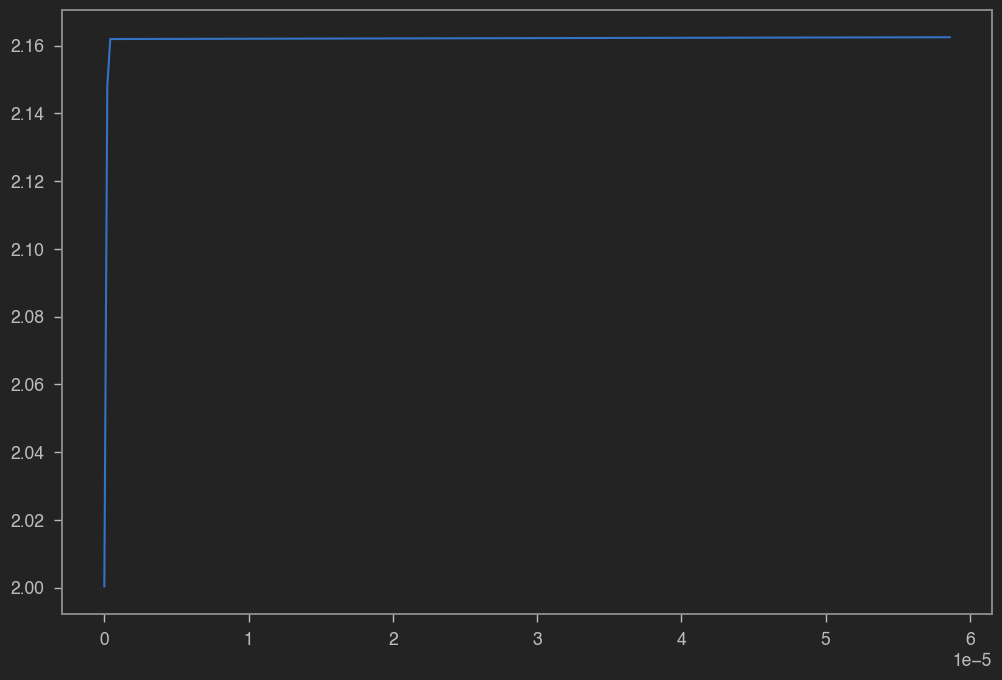

In [407]:
plt.plot(sim_cha.solution.t*0.0211/3600, sim_cha.solution['Terminal voltage [V]'].entries)

In [408]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = int(.3*3600/0.0211)#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        print("Time's up!")
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

    
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 500 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(500)
    except:
        condition = False
        
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(1)
    except:
        condition = False






 Trying 500 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 100 










 Trying 50 










 Trying 10 










 Trying 1 







Text(0, 0.5, 'Voltage [V]')

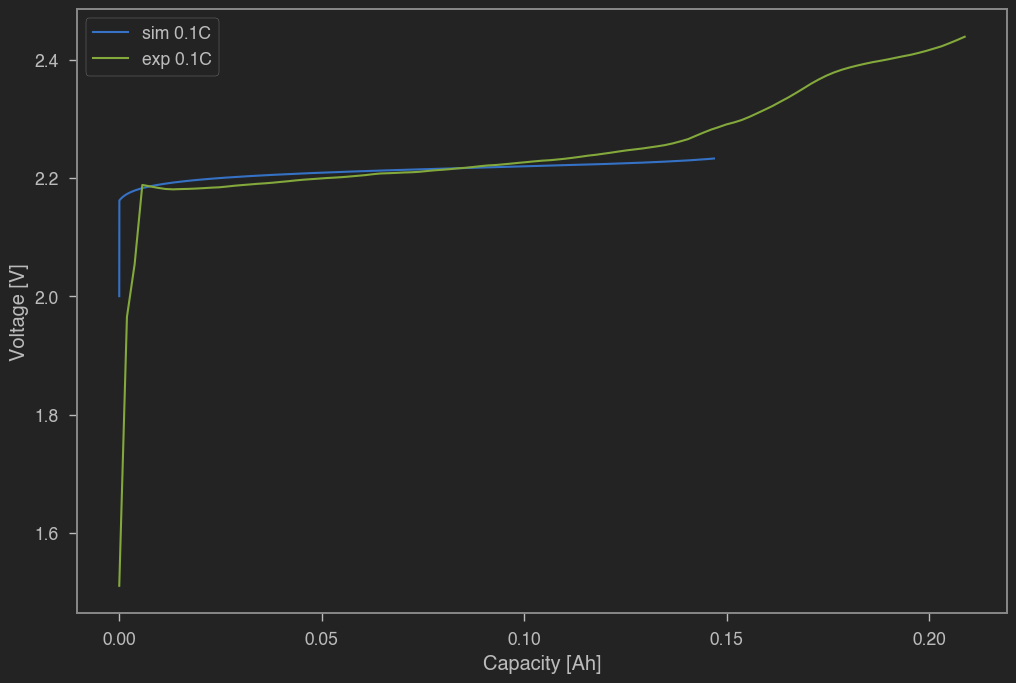

In [409]:
capacity = 0.0211*sim_cha.solution.t/3600
V = sim_cha.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)
string = str((Sp_initial_cha,S_star,kp))

# get experimental data
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C", "exp 0.1C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

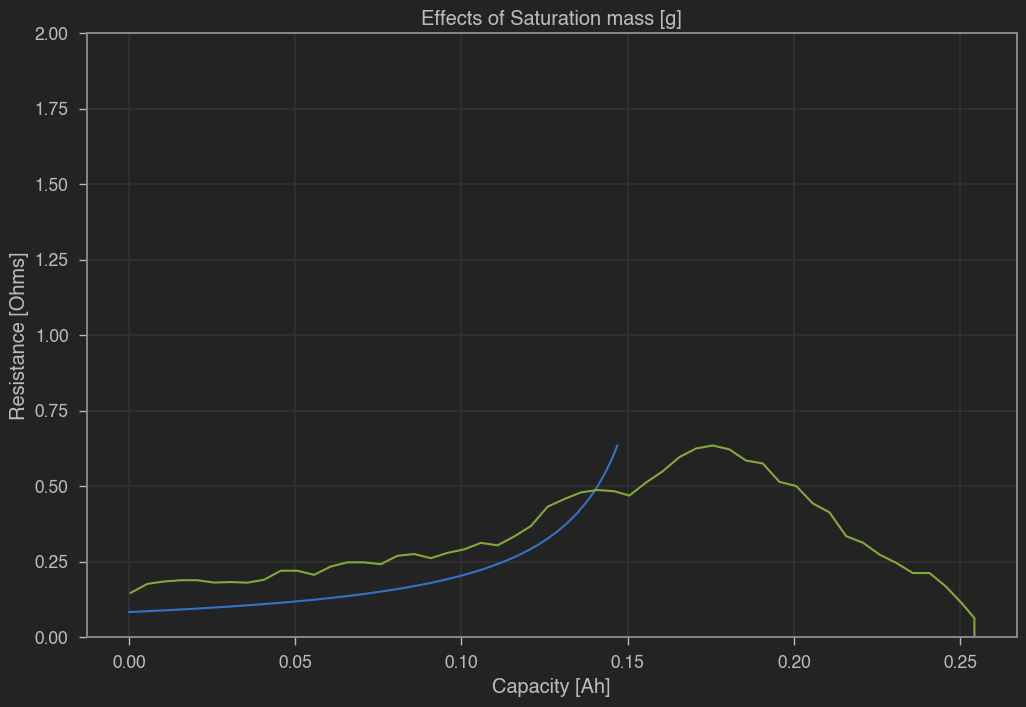

In [410]:
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity = .0211*sim_cha.solution.t/3600
S4 = sim_cha.solution['S4 [g]'].entries
S2 = sim_cha.solution['S2 [g]'].entries
S1 = sim_cha.solution['S [g]'].entries
Li_cha = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li_cha)
R = l/(A*sigma)
#plt.plot(capacity,R)
R_cha = 1/(max(Li_cha)*1.15-Li_cha)


#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(sim_cha.solution.t*0.0211/3600,max(res_charge_data['30'][1])*R_cha/max(R_cha))

plt.plot(res_charge_data['30'][0],res_charge_data['30'][1])

plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)

In [341]:
loc = -10
S1_initial = sim_cha.solution['S [g]'].entries[loc]
S2_initial = sim_cha.solution['S2 [g]'].entries[loc]
S4_initial = sim_cha.solution['S4 [g]'].entries[loc]
S8_initial = sim_cha.solution['S8 [g]'].entries[loc]
Sp_initial = sim_cha.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_cha.solution['Terminal voltage [V]'].entries[loc]
cap_temp = sim_cha.solution.t[loc]*0.0221/3600
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)
print(cap_temp)

0.1723844038725486
0.17663313704690253
0.08180072960232777
9.269944373252433e-11
9.5580318524641e-06
2.4392509646183256
0.2885891666666667


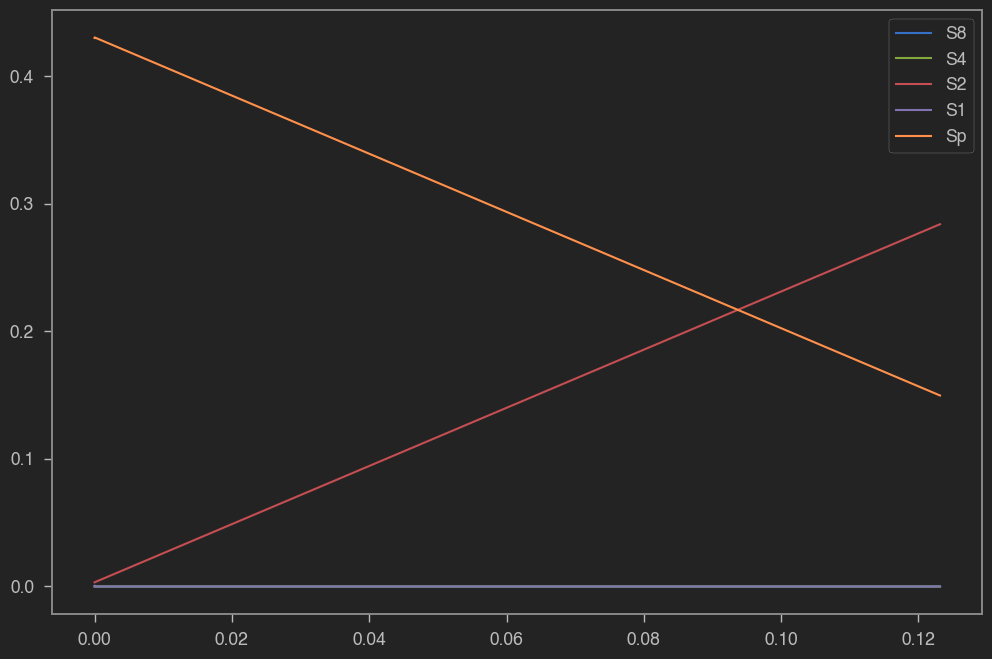

In [390]:
plt.plot(sim_cha.solution.t*0.0221/3600,sim_cha.solution['S8 [g]'].entries)
plt.plot(sim_cha.solution.t*0.0221/3600,sim_cha.solution['S4 [g]'].entries)
plt.plot(sim_cha.solution.t*0.0221/3600,sim_cha.solution['S2 [g]'].entries)
plt.plot(sim_cha.solution.t*0.0221/3600,sim_cha.solution['S [g]'].entries)
plt.plot(sim_cha.solution.t*0.0221/3600,sim_cha.solution['Precipitated Sulfur [g]'].entries)
plt.legend(['S8','S4','S2','S1','Sp'])

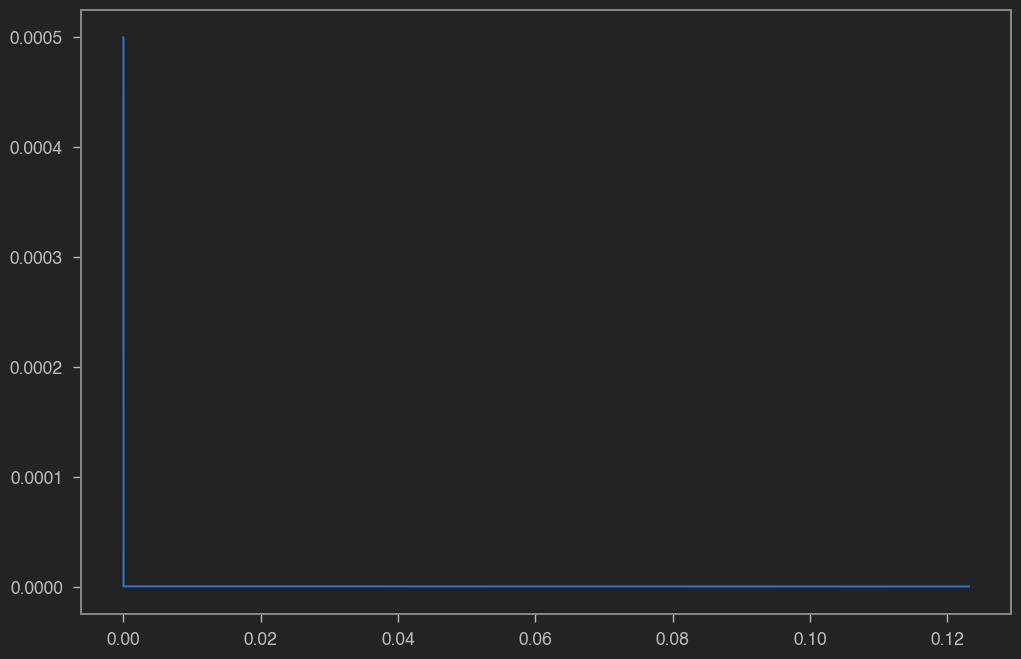

In [391]:
plt.plot(sim_cha.solution.t*0.0221/3600,sim_cha.solution['S [g]'].entries)

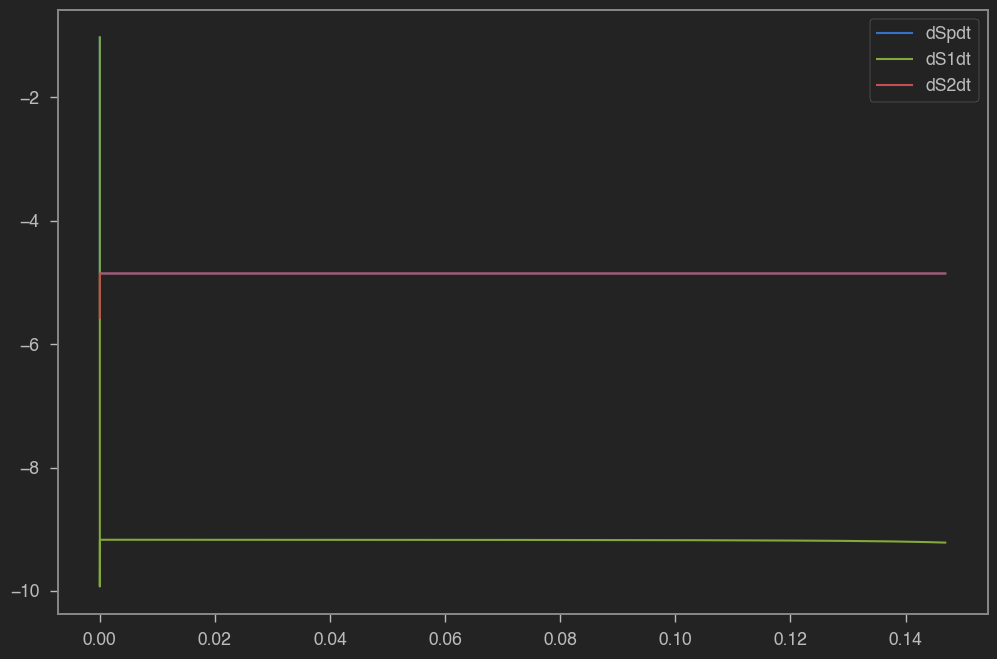

In [411]:
i_L = sim_cha.solution['Low plateau current [A]'].entries
Sp = sim_cha.solution['Precipitated Sulfur [g]'].entries
S1 = sim_cha.solution['S [g]'].entries
S2 = sim_cha.solution['S2 [g]'].entries
cap = sim_cha.solution.t*0.0211/3600

dSpdt = kp * Sp * (S1 - S_star) / (nu * 2000)
lower_partial = 2 * Ms * i_L / (1 * F)
dS1dt = lower_partial - dSpdt
mid_partial = 2 * Ms * sim_cha.solution['Middle plateau current [A]'].entries / (1 * F)
dS2dt = mid_partial - lower_partial 

plt.plot(cap, np.log10(abs(dSpdt)))
plt.plot(cap, np.log10(abs(dS1dt)))
plt.plot(cap, np.log10(abs(dS2dt)))

plt.legend(['dSpdt','dS1dt','dS2dt'])

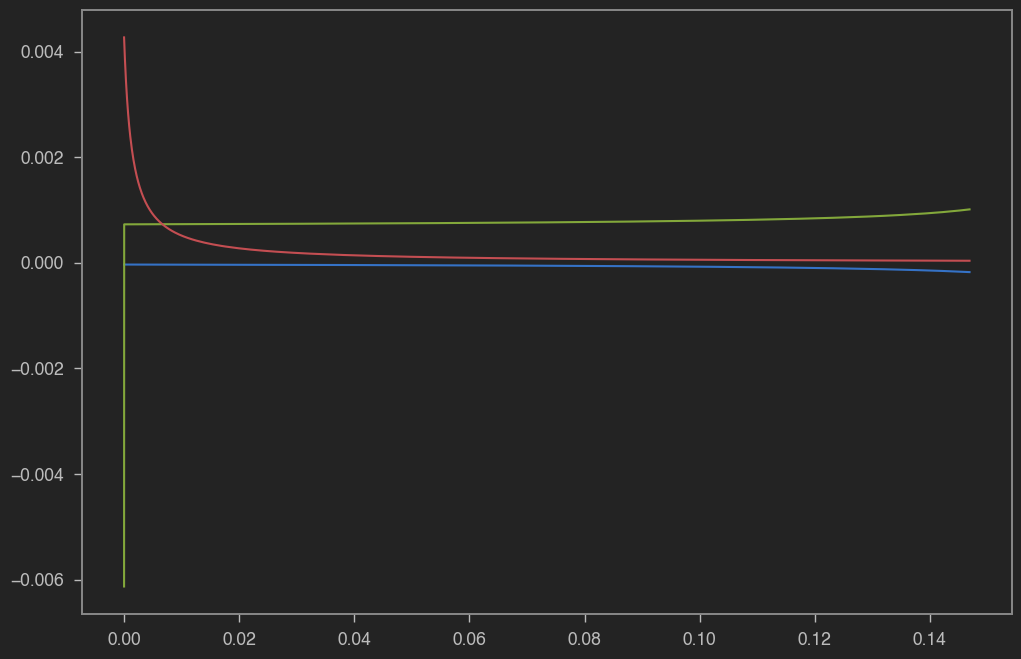

In [414]:
loc = 10

plt.plot(cap[loc:], dSpdt[loc:]/Sp[loc:])
plt.plot(cap[loc:], dS1dt[loc:]/S1[loc:])
plt.plot(cap[loc:], dS2dt[loc:]/S2[loc:])

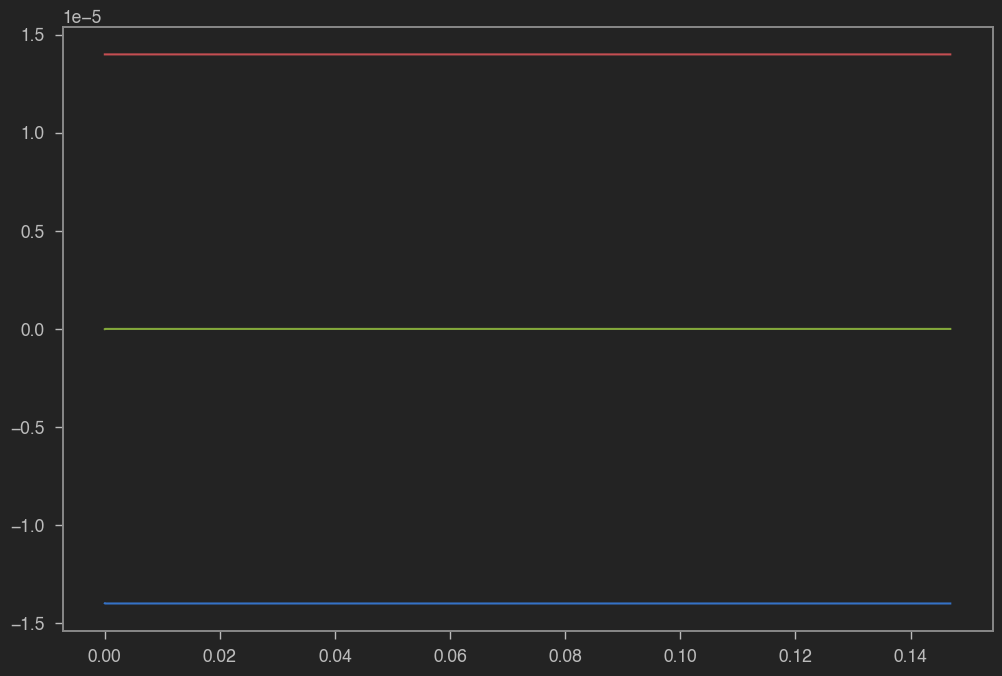

In [415]:
loc = 10

plt.plot(cap[loc:], dSpdt[loc:])
plt.plot(cap[loc:], dS1dt[loc:])
plt.plot(cap[loc:], dS2dt[loc:])

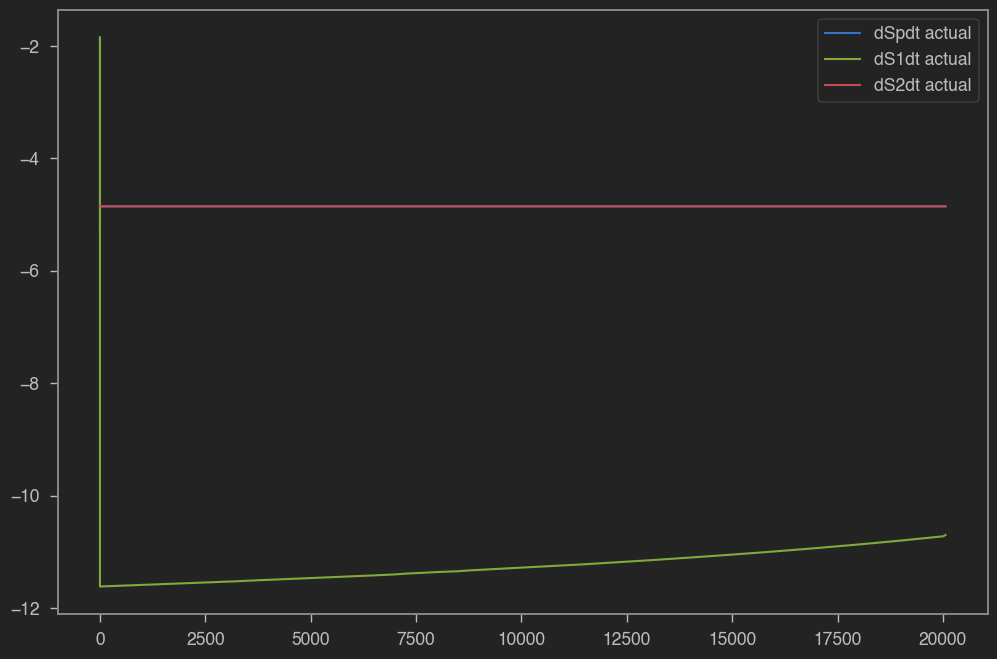

In [393]:
plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(Sp)/np.diff(sim_cha.solution.t))))
plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(S1)/np.diff(sim_cha.solution.t))))
plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(S2)/np.diff(sim_cha.solution.t))))
plt.legend(['dSpdt actual','dS1dt actual','dS2dt actual'])

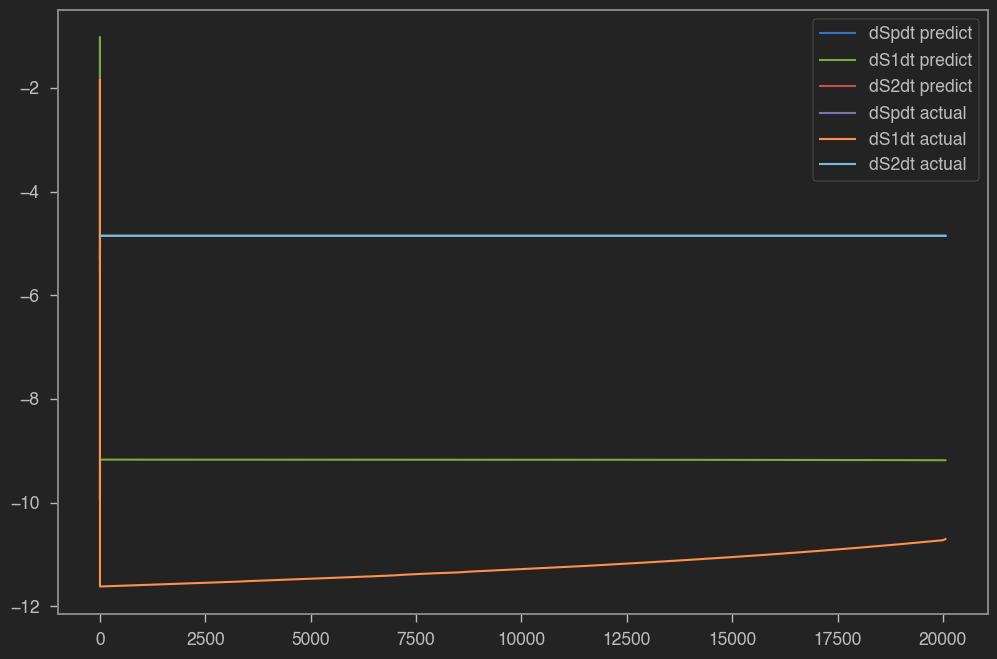

In [394]:
plt.plot(sim_cha.solution.t, np.log10(abs(dSpdt)))
plt.plot(sim_cha.solution.t, np.log10(abs(dS1dt)))
plt.plot(sim_cha.solution.t, np.log10(abs(dS2dt)))

plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(Sp)/np.diff(sim_cha.solution.t))))
plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(S1)/np.diff(sim_cha.solution.t))))
plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(S2)/np.diff(sim_cha.solution.t))))
plt.legend(['dSpdt predict','dS1dt predict','dS2dt predict','dSpdt actual','dS1dt actual','dS2dt actual'])

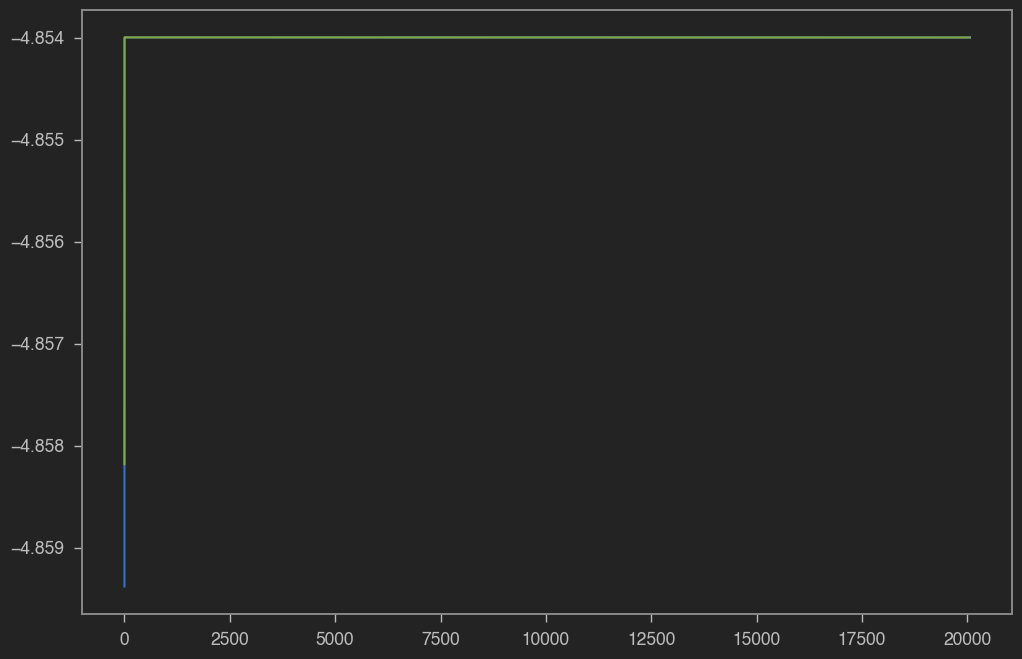

In [404]:
plt.plot(sim_cha.solution.t[2:], np.log10(abs(dSpdt[2:])))


plt.plot(sim_cha.solution.t[3:], np.log10(abs(np.diff(Sp[2:])/np.diff(sim_cha.solution.t[2:]))))


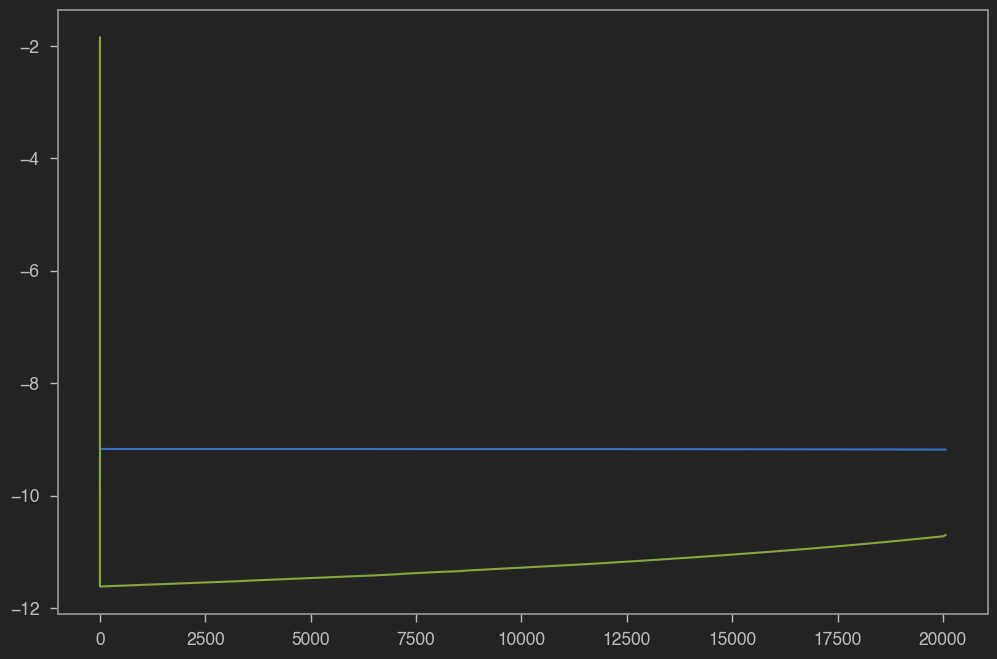

In [399]:

plt.plot(sim_cha.solution.t[1:], np.log10(abs(dS1dt[1:])))

plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(S1)/np.diff(sim_cha.solution.t))))


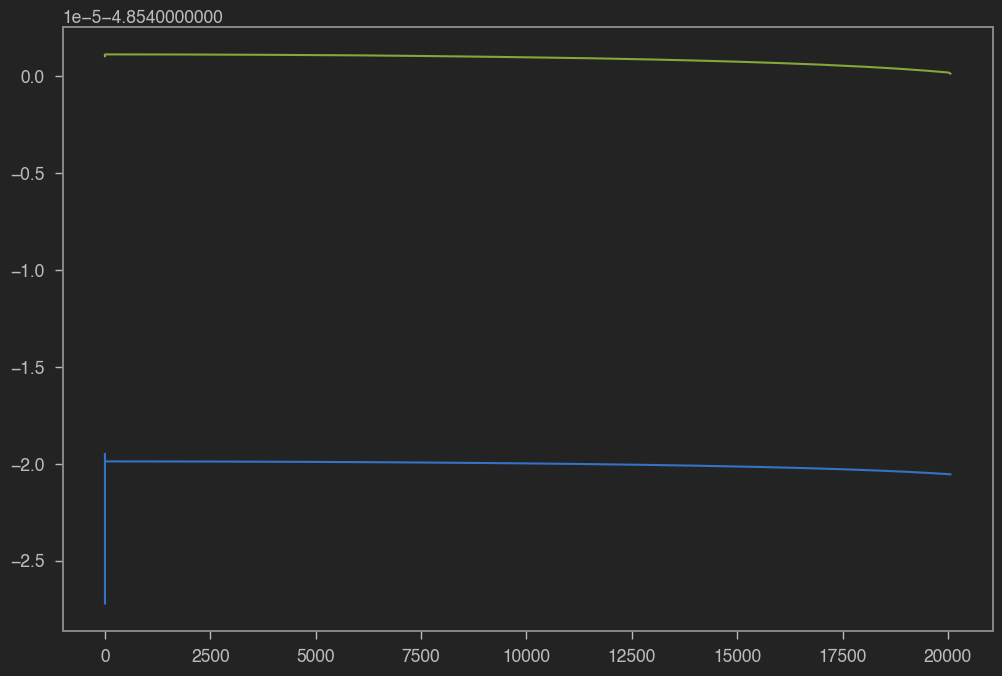

In [398]:

plt.plot(sim_cha.solution.t[1:], np.log10(abs(dS2dt[1:])))


plt.plot(sim_cha.solution.t[1:], np.log10(abs(np.diff(S2)/np.diff(sim_cha.solution.t))))

In [340]:
model_dis = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_dis = model_dis.default_parameter_values
param_dis.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,#*.0145,
        'gamma': 0,#10e1,#10,#10e40,#10,
        'kappa': 0,#10e10,#10e28,#10e80,
        'Shuttle rate coefficient during charge [s-1]': 0.00001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 50
        
        }
)


sim_dis = pybamm.Simulation(
    model_dis,
    #experiment=experiment,
    parameter_values = param_dis,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 10#3875#3840#.67*7000#16950#3600*hours
sim_dis.solve(np.linspace(0, time_in_seconds,int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

KeyboardInterrupt: 

In [ ]:
plt.plot(sim_dis.solution.t*0.0211/3600, sim_dis.solution['Terminal voltage [V]'].entries)

In [333]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = int(.225*3600/0.0422)#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        print("Time's up!")
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

    
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 500 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(500)
    except:
        condition = False
        
condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_dis) or time_check(sim_dis) or voltage_check(sim_dis):
            break_condition = False
        else:
            sim_dis.step(1)
    except:
        condition = False






 Trying 500 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 7703.21 and h






 Trying 100 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 50 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 10 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






 Trying 1 







Text(0, 0.5, 'Voltage [V]')

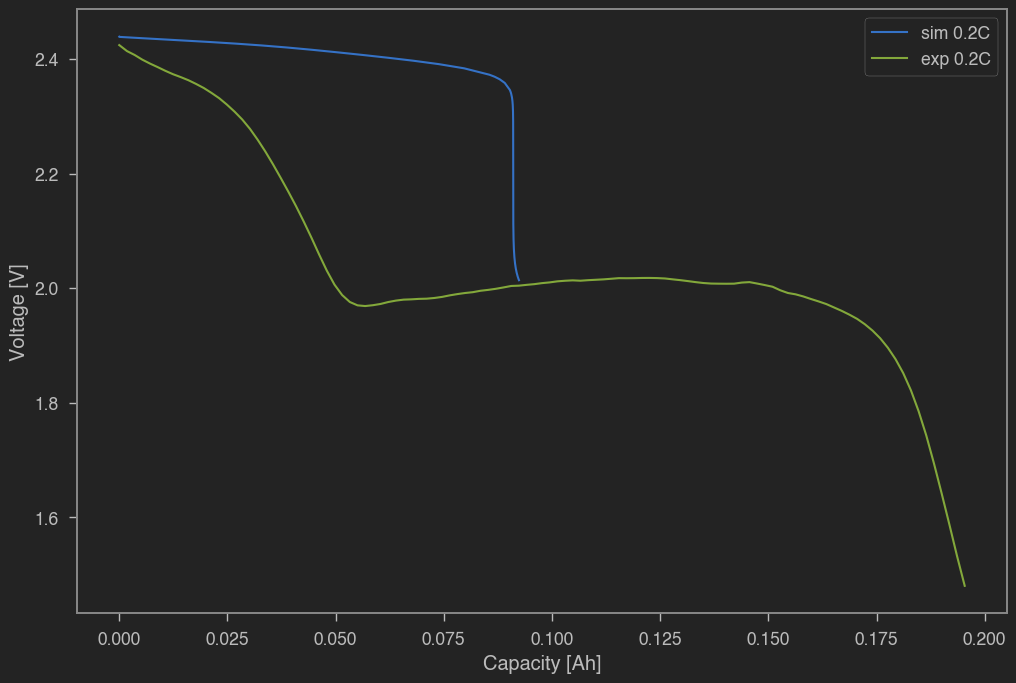

In [334]:
plt.plot(sim_dis.solution.t*0.0422/3600, sim_dis.solution['Terminal voltage [V]'].entries)

# get experimental data
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

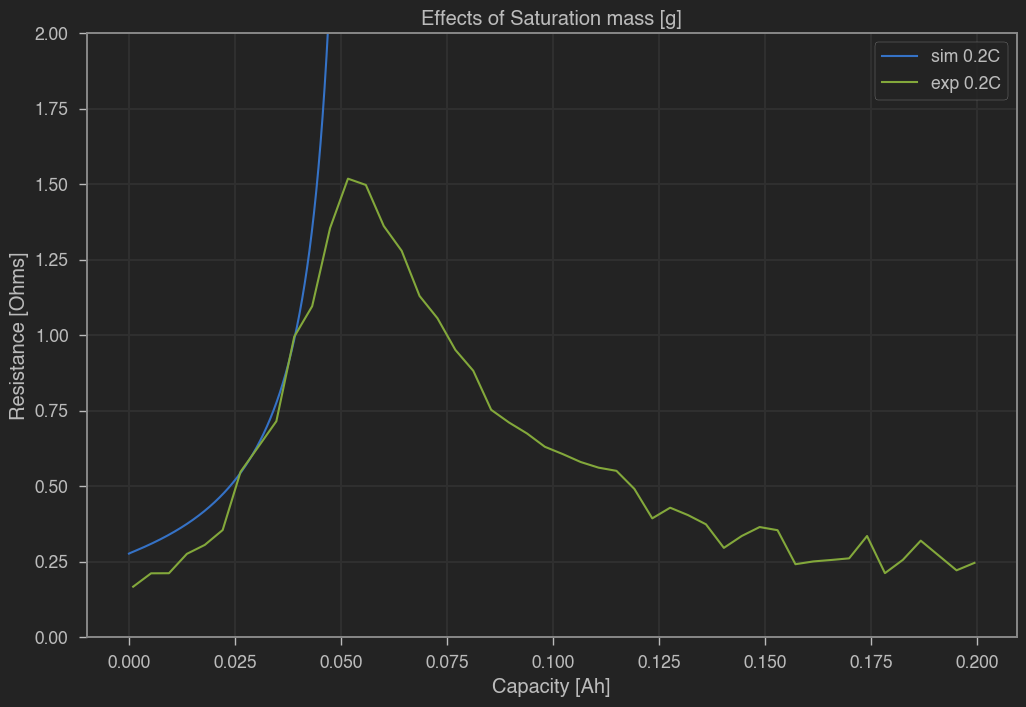

In [112]:
sigma_0 = 2e-2
l =  4e-5
A = 0.15

capacity = .0211*sim_dis.solution.t/3600
S4 = sim_dis.solution['S4 [g]'].entries
S2 = sim_dis.solution['S2 [g]'].entries
S1 = sim_dis.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 
b = 8e-2
sigma = sigma_0 - b*(Li)
R = l/(A*sigma)
#plt.plot(capacity,R)
R = 1/(max(Li_cha)*1.15-Li)


#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'
filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/red_data'

infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(sim_dis.solution.t*0.0422/3600,max(res_charge_data['30'][1])*R/max(R_cha))

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1])

plt.ylim([0,2])
#plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.grid(True)
plt.legend(["sim 0.2C","exp 0.2C" ])